### Objective: Which products will an Instacart consumer purchase again?
#### We'll apply some different models to observe their predictive performance. 

In [3]:
import pandas as pd
import numpy as np
pd.set_option('precision',4)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [41]:
# create validation data set, keeping features of importance
order_products_train_df = pd.read_csv("input/order_products__train.csv") 
order_products_train_df = order_products_train_df.drop(['add_to_cart_order'],axis=1)

orders_df = pd.read_csv('input/orders.csv')
orders_df = orders_df[orders_df.eval_set=='train'].iloc[:,:2]

temp_prior_orders_df = pd.read_csv('transformed/prior_order_features.csv')
temp_prior_orders_df = temp_prior_orders_df[['user_id','product_id','user_prod_reorder_rate','user_prod_reorders','prod_reorder_rate','user_orders','avg_add_to_cart_order']]

train_order_features_df = order_products_train_df.merge(orders_df, how='left', on='order_id').merge(temp_prior_orders_df, how='left', on=['user_id','product_id'])

In [15]:
train_order_features_df.sample(10)

,order_id,product_id,reordered,user_id,user_prod_reorder_rate,user_prod_reorders,prod_reorder_rate,user_orders,avg_add_to_cart_order
889086,630733,4329,1,88293,0.1600,4.0,0.5740,25.0,2.6000
4700605,3354403,47734,1,181340,0.0105,13.0,0.5186,1238.0,12.5000
1466586,1039446,31506,1,178241,0.0063,9.0,0.4766,1420.0,12.1000
1670738,1186685,11777,1,128201,0.0510,13.0,0.6430,255.0,8.1429
4624104,3303524,22795,0,55208,NaN,NaN,NaN,NaN,NaN
1348922,953497,47209,1,184236,0.0193,4.0,0.7966,207.0,3.4000
4417250,3159186,21137,1,77044,0.0174,14.0,0.7777,806.0,9.0000
2111569,1501280,19025,0,42845,NaN,NaN,NaN,NaN,NaN
3211721,2297270,4920,1,166441,0.0132,12.0,0.6673,907.0,12.2308
471432,327191,7781,1,7878,0.0053,1.0,0.7318,188.0,4.5000


In [28]:
# confirm record count and data types
train_order_features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4793796 entries, 0 to 4793795
Data columns (total 9 columns):
order_id                  int64
product_id                int64
reordered                 int64
user_id                   int64
user_prod_reorder_rate    float64
user_prod_reorders        float64
prod_reorder_rate         float64
user_orders               float64
avg_add_to_cart_order     float64
dtypes: float64(5), int64(4)
memory usage: 525.7 MB


In [42]:
# check ratio of reordered products vs non-reordered products
train_order_features_df.reordered.value_counts(normalize=True)

1    0.8841
0    0.1159
Name: reordered, dtype: float64

In [43]:
# capture sample and drop NaN records 
train_order_features_df = train_order_features_df.sample(frac=0.1)
train_order_features_df.shape

(479380, 9)

In [44]:
# ensure a similar balance of reordered vs non-reordered products remain
train_order_features_df.reordered.value_counts(normalize=True)

1    0.8839
0    0.1161
Name: reordered, dtype: float64

In [45]:
# replace NaN with '0'
train_orders_df = train_order_features_df.fillna(0)

In [46]:
# Write to file
train_orders_df.to_csv('transformed/train_order_features_sample.csv')

In [19]:
# read in prior orders feature sample dataset
prior_orders_df = pd.read_csv('transformed/prior_order_features_sample.csv')

In [48]:
# evaluate performance using LR

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# assign features and targets from training data
X_prior = prior_orders_df[['user_prod_reorder_rate','user_prod_reorders','prod_reorder_rate','user_orders','avg_add_to_cart_order']]
y_prior = prior_orders_df['reordered']

# initialize validation data
X_train = train_orders_df[['user_prod_reorder_rate','user_prod_reorders','prod_reorder_rate','user_orders','avg_add_to_cart_order']]
y_train = train_orders_df['reordered']

lr = LogisticRegression()
lr.fit(X_prior,y_prior)

# Calculate precision and recall scores
accuracy = lr.score(X_train,y_train)
precision = float(precision_score(y_train, lr.predict(X_train)))
recall = float(recall_score(y_train, lr.predict(X_train)))

print("The accuracy score is {:.1f}%.".format(accuracy*100))

print("The precision is {:.1f}% and the recall is {:.1f}%.".format(precision * 100, recall * 100))

The accuracy score is 86.6%.
The precision is 100.0% and the recall is 84.8%.


In [49]:
# determine null accuracy
y_train.value_counts(normalize=True)

1    0.8839
0    0.1161
Name: reordered, dtype: float64

_It appears the LR model has very high precision and perfect recall, far exceeding the null accuracy baseline._

Text(0.5,0,u'False Positive Rate')

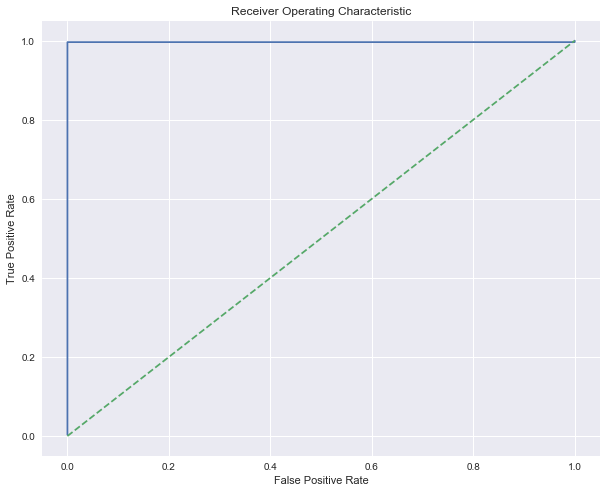

In [50]:
# Visualize precision and recall using ROC curve

from sklearn.metrics import roc_curve, roc_auc_score

y_prob = lr.predict_proba(X_train)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(y_train, y_prob)

plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [51]:
# Calculate the area under the curve using AUROC score
# The estimated probability that a uniformly drawn random positive is ranked before a uniformly drawn random negative.
ras = roc_auc_score(y_train, y_prob)
print("The AUROC score is {:.1f}%.".format(ras*100))

The AUROC score is 99.6%.


In [52]:
# Let's take a look at how some other models perform

from sklearn import ensemble, neighbors
from sklearn.model_selection import cross_val_score

cls = ensemble.RandomForestClassifier(n_estimators=50) 
cls.fit(X_prior, y_prior)

print ('Random Forest: {:.1f}%.'.format( cross_val_score(cls, X_train, y_train, scoring='roc_auc', cv=5).mean() * 100 ))
    
cls = ensemble.GradientBoostingClassifier(n_estimators=50) 
cls.fit(X_prior, y_prior)

print ('GBDT: {:.1f}%.'.format( cross_val_score(cls, X_train, y_train, scoring='roc_auc', cv=5).mean() * 100 ))
    
cls = neighbors.KNeighborsClassifier(n_neighbors=5)
cls.fit(X_prior, y_prior)

print ('KNN: {:.1f}%.'.format( cross_val_score(cls, X_train, y_train, scoring='roc_auc', cv=5).mean() * 100 ))

Random Forest: 100.0%.
GBDT: 100.0%.
KNN: 100.0%.
